In [1]:
import numpy as np
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Dataset

In [3]:
!unzip -P 2019Deepfashion2** /content/drive/MyDrive/ECE1508\ DL\ Project/validation.zip  -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/validation/image/007349.jpg  
  inflating: /content/validation/image/007310.jpg  
  inflating: /content/validation/image/007286.jpg  
  inflating: /content/validation/image/007274.jpg  
  inflating: /content/validation/image/007218.jpg  
  inflating: /content/validation/image/007216.jpg  
  inflating: /content/validation/image/007204.jpg  
  inflating: /content/validation/image/007133.jpg  
  inflating: /content/validation/image/007081.jpg  
  inflating: /content/validation/image/007045.jpg  
  inflating: /content/validation/image/007044.jpg  
  inflating: /content/validation/image/007017.jpg  
  inflating: /content/validation/image/006960.jpg  
  inflating: /content/validation/image/006868.jpg  
  inflating: /content/validation/image/006831.jpg  
  inflating: /content/validation/image/006773.jpg  
  inflating: /content/validation/image/006744.jpg  
  inflating: /content/validation/image/006720.jpg  
  inflating: 

In [ ]:
!ls /content/validation/image -1 -R | wc -l

## Dataframe of Dataset

In [ ]:
with open('/content/validation/annos/000002.json') as f:
  test_anno = json.load(f)

In [ ]:
test_anno.keys()

In [ ]:
test_anno['item1'].keys()

In [3]:
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm

root_dir = '/content/validation'
image_dir = os.path.join(root_dir, 'image')
annotation_dir = os.path.join(root_dir, 'annos')
image_files = os.listdir(image_dir)

def load_data(img_file):
    img_name = os.path.join(image_dir, img_file)
    annotation_name = os.path.join(annotation_dir, os.path.splitext(img_file)[0] + '.json')

    # Load annotation
    with open(annotation_name) as f:
        annotation = json.load(f)

    # Extract specific keys and their nested values
    item1 = annotation.get('item1', {})
    item2 = annotation.get('item2', {})

    item1_category_name = item1.get('category_name', None)
    item1_scale = item1.get('scale', None)
    item1_bounding_box = item1.get('bounding_box', None)
    item1_category_id = item1.get('category_id', None)

    item2_category_name = item2.get('category_name', None)
    item2_scale = item2.get('scale', None)
    item2_bounding_box = item2.get('bounding_box', None)
    item2_category_id = item2.get('category_id', None)

    return {
            'image_file': img_file,
            'item1_category_name': item1_category_name,
            'item1_scale': item1_scale,
            'item1_bounding_box': item1_bounding_box,
            'item1_category_id': item1_category_id,
            'item2_category_name': item2_category_name,
            'item2_scale': item2_scale,
            'item2_bounding_box': item2_bounding_box,
            'item2_category_id': item2_category_id}

# Create a pool of workers
num_workers = os.cpu_count()  # Use the number of CPU cores
with Pool(num_workers) as pool:
    data = list(tqdm(pool.imap(load_data, image_files), total=len(image_files)))

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Example:
print(df.head())  # Display the first few rows of the DataFrame

100%|██████████| 32153/32153 [00:18<00:00, 1775.74it/s]


   image_file item1_category_name  item1_scale    item1_bounding_box  \
0  025749.jpg          vest dress            3     [26, 0, 587, 479]   
1  031457.jpg     long sleeve top            3   [51, 234, 554, 841]   
2  011505.jpg               sling            1  [234, 159, 400, 374]   
3  007359.jpg    short sleeve top            2   [68, 251, 287, 589]   
4  011383.jpg     long sleeve top            2  [228, 166, 529, 611]   

   item1_category_id item2_category_name  item2_scale    item2_bounding_box  \
0                 12     long sleeve top          3.0     [16, 0, 639, 479]   
1                  2            trousers          2.0  [145, 722, 449, 958]   
2                  6            trousers          1.0  [233, 350, 397, 781]   
3                  1               skirt          2.0  [140, 465, 432, 623]   
4                  2              shorts          1.0  [257, 473, 498, 624]   

   item2_category_id  
0                2.0  
1                8.0  
2                8.0  


In [ ]:
df['item1_category_name'].value_counts(normalize=True)

short sleeve top        0.298666
long sleeve top         0.137281
short sleeve dress      0.094113
vest dress              0.093117
trousers                0.086835
skirt                   0.067054
vest                    0.054521
long sleeve outwear     0.052686
long sleeve dress       0.043635
shorts                  0.037322
sling dress             0.022580
sling                   0.008864
short sleeve outwear    0.003328
Name: item1_category_name, dtype: float64

In [ ]:
df['item2_category_name'].value_counts(normalize=True)

trousers                0.325697
skirt                   0.220761
shorts                  0.149314
short sleeve top        0.145411
long sleeve top         0.074323
sling dress             0.021265
vest                    0.018029
vest dress              0.017823
long sleeve outwear     0.015409
short sleeve dress      0.004623
long sleeve dress       0.003801
short sleeve outwear    0.001798
sling                   0.001746
Name: item2_category_name, dtype: float64

In [ ]:
df[df['item2_category_name'].isna()].shape

(12684, 9)

## Create a Category Vector (label)

In [4]:
item_categories = {}
unique_categories =  df['item1_category_name'].unique()

# Create dictionary of classes (type of clothing present in dataset)
for i in range(len(unique_categories)):
  item_categories[unique_categories[i]] = i

def category_vector(categories):
  """
  Create a vector length of the total number of classes with binary values representing if a class is present (1) or not (0)
  """

  output = []
  for i in item_categories.keys():
    if i in categories:
      output.append(1)
    else:
      output.append(0)

  return output

## Create custom dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'image')
        self.annotation_dir = os.path.join(root_dir, 'annos')
        self.image_files = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        annotation_name = os.path.join(self.annotation_dir, os.path.splitext(self.image_files[idx])[0] + '.json')

        # Create image
        image = Image.open(img_name).convert('RGB')

        with open(annotation_name) as f:
            annotation = json.load(f)

        # Extract specific keys and their nested values
        item1 = annotation.get('item1', {})
        item2 = annotation.get('item2', {})

        item1_category_name = item1.get('category_name', None)
        item1_bounding_box = item1.get('bounding_box', None)

        item2_category_name = item2.get('category_name', None)
        item2_bounding_box = item2.get('bounding_box', None)

        # Create label (category + bbox)
        image = np.array(image)
        category = [(item1_category_name, item2_category_name), category_vector([item1_category_name, item2_category_name])] # Set of categories and a vector with binary values
        bbox = [item1_bounding_box, item2_bounding_box]

        return image, category, bbox

# Create dataset
dataset = CustomDataset('/content/validation')

## Dataset Split

In [6]:
import random
import multiprocessing
from functools import partial

def data_splitter(dataset, dataset_size, train_size):
  """
  Splits data randomly into test and train according to the specified train size
  """

  indicies = random.sample(range(0, dataset.__len__()), dataset_size)
  train_indicies = random.sample(indicies, train_size)

  # Create training dataset
  train_dataset = []
  for i in train_indicies:
    image, category, bbox = dataset.__getitem__(i)

    for j in bbox:
      if j == None:
        bbox.remove(None)

    train_dataset.append((image, category, bbox))

  # Create testing dataset
  test_dataset = []
  for i in indicies:
    if i not in train_indicies:
      image, category, bbox = dataset.__getitem__(i)

      for j in bbox:
        if j == None:
          bbox.remove(None)

      test_dataset.append((image, category, bbox))

  return train_dataset, test_dataset


In [7]:
# Create dataset for training and testing (images + labels stored in arrays)
train_data, test_data = data_splitter(dataset, 500, 350)

## Define CNN Architecture (VGG16)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        # Load the pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze parameters of the pre-trained VGG16 layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Modify the last fully connected layer to output num_classes
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
        self.vgg16.classifier[6].requires_grad = True

    def forward(self, x):
        # Forward pass through the VGG16 model
        x = self.vgg16(x)
        x = F.softmax(x, dim=1) # Softmax as vector activation at output layer

        return x

# Number of classes for the classification task
num_classes = len(unique_categories)

# Initialize the VGG16 model for multiclass classification
model = VGG16(num_classes)
summary(model, (3, 244, 244))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

## Regional Proposals for Training

In [9]:
import cv2, keras
import matplotlib.pyplot as plt

def get_iou(bb1, bb2):
    """
    Determines IoU between 2 bounding boxes
    Derived from: https://github.com/1297rohit/RCNN/blob/master/RCNN.ipynb
    """

    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0

    return iou


In [10]:
# Code derived from: https://github.com/1297rohit/RCNN/blob/master/RCNN.ipynb
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

train_images=[]
train_labels=[]

## For each image in training set, perform selective search and retrieve region proposals
for i, (image, category, bbox) in enumerate(train_data[:30]): # Only using 30 images to train due to slow training time
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process() # Results of selective search of image
  imout = image.copy()
  counter = 0
  falsecounter = 0
  flag = 0
  fflag = 0
  bflag = 0

  # Iterate through region proposals for an image
  for e, result in enumerate(ssresults):
      # Look at first 1000 region proposals
      if e < 1000 and flag == 0:
          k = 0
          for j in bbox:
              x,y,w,h = result
              iou = get_iou(j, [x, x+w, y, y+h]) # Determine IoU
              if counter < 30:
                  if iou > 0.70: # Means region has an item inside (corresponding category of bbox)
                      timage = imout[y:y+h,x:x+w]
                      resized = np.transpose(cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA), (2, 0, 1))
                      train_images.append(resized)
                      train_labels.append(category_vector([category[0][k]]))
                      k+=1
                      counter += 1
              else :
                  fflag = 1
              if falsecounter < 30:
                  if iou < 0.3: # Means region does not have an item inside
                      timage = imout[y:y+h,x:x+w]
                      resized = np.transpose(cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA), (2, 0, 1))
                      train_images.append(resized)
                      train_labels.append(category_vector(["a"]))
                      k+=1
                      falsecounter += 1
              else :
                  bflag = 1

          if fflag == 1 and bflag == 1:
              print("inside")
              flag = 1

# Images and labels of region proposals
X_new = np.array(train_images)
y_new = np.array(train_labels)

inside


In [11]:
def test(model, loss_function):

    with torch.no_grad():
        risk = 0
        accuracy = 0

        for i, (image, category, bbox) in enumerate(test_data[:5]): # Only using 5 images due to long testing time
          test_images=[]
          label = torch.tensor(category[1], dtype=torch.float32)

          # Perform Selective Search on test images
          ss.setBaseImage(image)
          ss.switchToSelectiveSearchFast()
          ssresults = ss.process()
          imout = image.copy()

          for e, result in enumerate(ssresults):
              if e < 250:
                  x,y,w,h = result
                  timage = imout[y:y+h,x:x+w]
                  resized = np.transpose(cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA), (2, 0, 1))
                  test_images.append(resized) # Region proposals for test images

          batch_size = 2
          data_loader = torch.utils.data.DataLoader(test_images, batch_size=batch_size, shuffle=True)
          predictions = [0]*len(unique_categories)

          for j, (images) in enumerate(data_loader):
              images = torch.tensor(images, dtype=torch.float32)
              outputs = model.forward(images)
              outputs_np = outputs.cpu().detach().numpy()
              predictions = [prediction + 1 if value > 0.5 else prediction for prediction, value in zip(predictions, outputs_np[0])] # Add up predictions for image

          predictions = torch.tensor([x/(j+1) for x in predictions]) # Divide predictions by number of iterations for the image
          loss = loss_function(predictions, label)

          # compute the fraction of correctly predicted labels
          correct_predict = (predictions == label).sum().item()/len(label)

          risk += loss
          accuracy += correct_predict

        # average test risk and accuracy over the whole test dataset
        test_risk = risk/(i+1)
        test_accuracy = accuracy/(i+1)

    return test_risk, test_accuracy

In [ ]:
# test_risk, test_accuracy = test(model, nn.BCELoss())

In [12]:
def train(model, num_epochs):

    # set loss to binary CE
    loss_function = nn.BCELoss()

    # Set optimizer with optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    # Initiate the values
    train_risk = []
    test_risk = []
    test_accuracy = []

    data_tuples = list(zip(X_new, y_new))
    batch_size = 2
    data_loader = torch.utils.data.DataLoader(data_tuples, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0

        # loop over training data
        for i, (images, labels) in enumerate(data_loader):
            images = torch.tensor(images, dtype=torch.float32, requires_grad=True)
            labels = torch.tensor(labels, dtype=torch.float32, requires_grad=True)

            # forward pass
            outputs = model.forward(images)

            predictions = (outputs > 0.5).float()
            loss = loss_function(predictions, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()

            # compute the gradient of loss
            loss.backward()

            # one step of gradient descent
            optimizer.step()

        # test out model after update by the optimizer
        risk_epoch, accuracy_epoch = test(model, loss_function)

        # collect losses and accuracy
        train_risk.append(risk/i)
        test_risk.append(risk_epoch)
        test_accuracy.append(accuracy_epoch)

        # complete: write your message
        print("Currently finished epoch: ", epoch)

    # plot the losses
    plt.plot([i+1 for i in range(num_epochs)], train_risk)
    plt.plot([i+1 for i in range(num_epochs)], test_risk)
    plt.title("Train & Test Risks")
    plt.xlabel("Epoch")
    plt.ylabel("Risk")
    plt.legend(["Train Risk", "Test Risk"])
    plt.show()

    # plot the accuracy
    plt.plot([i+1 for i in range(num_epochs)], test_accuracy)
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    return train_risk, test_risk, test_accuracy

## Testing

<ipython-input-12-2e44634bfd1a>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32, requires_grad=True)
<ipython-input-12-2e44634bfd1a>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, requires_grad=True)


0


<ipython-input-11-83091d6dc6bd>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)


1
2
3
4
Currently finished epoch:  0
0
1
2
3
4
Currently finished epoch:  1
0
1
2
3
4
Currently finished epoch:  2
0
1
2
3
4
Currently finished epoch:  3
0
1
2
3
4
Currently finished epoch:  4


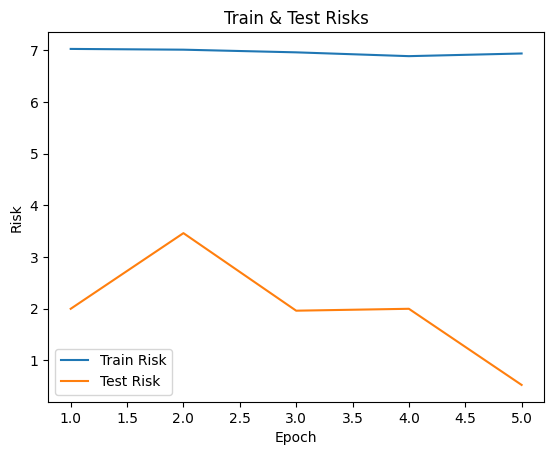

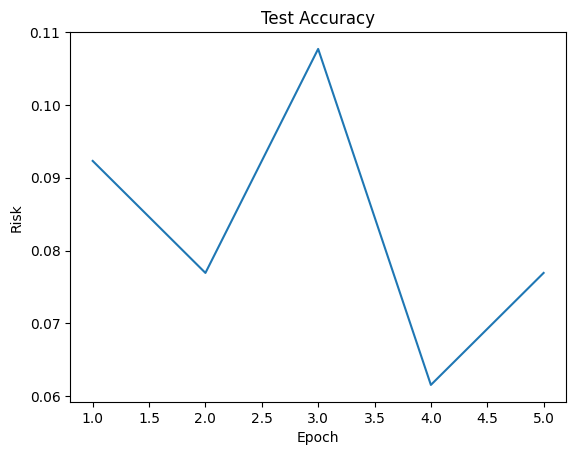

In [13]:
train_risk, test_risk, test_accuracy = train(model, 5)

In [14]:
print(train_risk)
print(test_risk)
print(test_accuracy)

[7.029177581670184, 7.014441365939904, 6.962864594441264, 6.889183486558468, 6.940760257143627]
[tensor(1.9958), tensor(3.4611), tensor(1.9590), tensor(1.9958), tensor(0.5212)]
[0.09230769230769231, 0.07692307692307693, 0.10769230769230771, 0.06153846153846154, 0.07692307692307693]


In [17]:
# Save weights of trained model
%cd /content/drive/My Drive
torch.save(model.state_dict(), '\R-CNN.pt')

/content/drive/My Drive
